In [1]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
tf.reset_default_graph()

In [3]:
num_samples = 100000

[ 0.69418603  0.82312483  0.62176192 ...,  0.99036455  0.03671897
  0.92052996]
[ 0.3881031   0.38662991  0.36872589 ...,  0.4180864   0.31265937
  0.37676896]


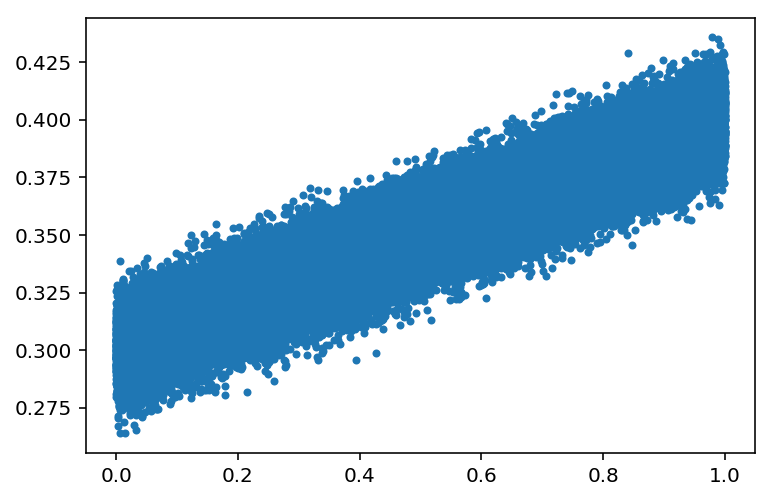

In [4]:
# 1.2 Create input data using NumPy. y = x * 0.1 + 0.3 + noise
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

# Pplot our input data.
pylab.plot(x_train, y_train, '.')

[ 0.18656415  0.1735352   0.7358126  ...,  0.89046687  0.64063728
  0.40266216]
[ 0.30394852  0.32549256  0.36022167 ...,  0.38389632  0.3766102
  0.35133157]


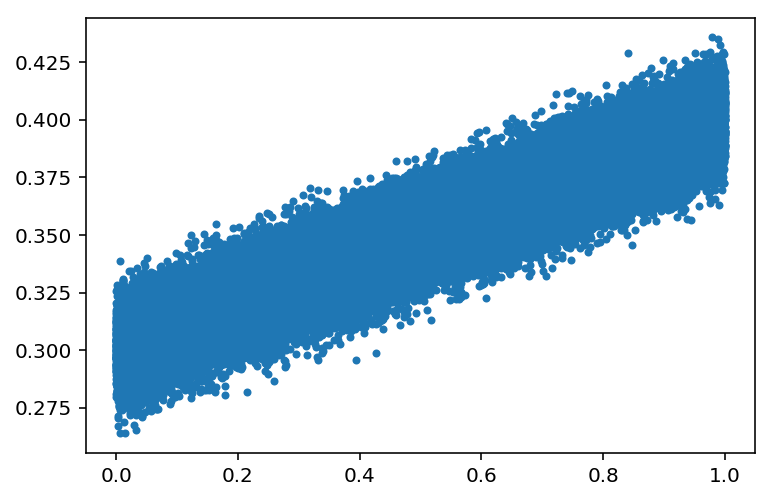

In [5]:
# Create some fake test/validation data
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_train, y_train, '.')

In [6]:
# 1.3 Build inference graph.
# Create Variables W and b that compute y = W * x + b
with tf.device("/cpu:0"):
  W = tf.get_variable(shape=[], name='weights')
  print(W)

  b = tf.get_variable(shape=[], name='bias')
  print(b)

  # Create a placeholder we'll use later to feed x's into the graph for training and test.
  # shape=[None] means we can put in any number of examples. 
  # This is used for minibatch training, and to evaluate a lot of examples at once.
  x_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='x_observed')
  print(x_observed)

with tf.device("/cpu:0"):
#  with jit_scope():
    # Same as tf.add(tf.matmul(W, tf.transpose(x)), b)
    y_pred = W * x_observed + b
    print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:CPU:0)


In [7]:
# 1.4 Build training graph.
# Create an operation that calculates loss.

# Create a placeholder we'll use later to feed the correct y value into the graph
with tf.device("/cpu:0"):
#  with jit_scope():
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))

    # Create an optimizer.
    optimizer_op = tf.train.GradientDescentOptimizer(0.025)  

    # Create an operation that minimizes loss.
    train_op = optimizer_op.minimize(loss_op)  

    # 'loss', 'optimizer' and 'train' are.
    print("loss:", loss_op)
    print("optimizer:", optimizer_op)
    print("train:", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
loss: Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)
optimizer: <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f229adb2278>
train: name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



In [8]:
# Create an operation to initialize all the variables.
with tf.device("/cpu:0"):
  init_op = tf.global_variables_initializer()
  print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [9]:
config = tf.ConfigProto(
  log_device_placement=True,
)

print(config)

log_device_placement: true



In [10]:
# Write the graph so we can look at it in TensorBoard
# Now is a good time to try that
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/train' % version, graph=tf.get_default_graph())
test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/test' % version, graph=tf.get_default_graph())

print(version)

1490850372


In [11]:
sess = tf.Session(config=config)
sess.run(init_op)

print(sess.run(W))
print(sess.run(b))

0.413219
-1.52509


## Accuracy of Random Weights

In [12]:
# Convenience method for evaluating the loss (error)
def test(x, y):
  return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [13]:
# Calculate accuracy on the test data using random initial values for y
# Note:  This should be relatively far from 0 since we haven't yet trained the model
test(x=x_test, y=y_test)

2.7930825

In [14]:
# Add a Summary Operation so we can visualize the loss in TensorBoard
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

# Train Model

In [15]:
%%time

max_steps = 300

run_metadata = tf.RunMetadata()

for step in range(max_steps):
  # Run the training op; feed the training data into the graph
  if (step < max_steps):
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
  else:  
    test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
    train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), run_metadata=run_metadata)
    trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
    with open('cpu-timeline.json', 'w') as trace_file:
      trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

# The following take a relatively long time, so do them at periodic intervals
  if step % 5 == 0:
    print(step, sess.run([W, b]))
    train_summary_writer.add_summary(train_summary_log, step)
    train_summary_writer.flush()
    test_summary_writer.add_summary(test_summary_log, step)
    test_summary_writer.flush()

0 [0.45358154, -1.4416615]
5 [0.61740506, -1.0959444]
10 [0.7312094, -0.84441686]
15 [0.80902487, -0.66082871]
20 [0.86096489, -0.52625561]
25 [0.89431924, -0.42705417]
30 [0.91434193, -0.35338816]
35 [0.92481965, -0.29816616]
40 [0.9284811, -0.25627512]
45 [0.92729223, -0.22402853]
50 [0.92266959, -0.19876823]
55 [0.91563308, -0.17857733]
60 [0.90691704, -0.16207345]
65 [0.89704984, -0.14825945]
70 [0.88641137, -0.13641596]
75 [0.87527472, -0.12602387]
80 [0.86383563, -0.11670849]
85 [0.8522343, -0.10819916]
90 [0.84057093, -0.10030027]
95 [0.82891697, -0.09287034]
100 [0.81732279, -0.085806891]
105 [0.80582404, -0.079035595]
110 [0.79444557, -0.072502412]
115 [0.78320426, -0.066167921]
120 [0.77211159, -0.060003262]
125 [0.76117498, -0.053987198]
130 [0.75039911, -0.048103984]
135 [0.73978633, -0.042341862]
140 [0.72933775, -0.036691926]
145 [0.71905327, -0.031147355]
150 [0.70893228, -0.025702834]
155 [0.69897342, -0.020354141]
160 [0.68917495, -0.01509783]
165 [0.67953503, -0.00993

(0, 1.0)

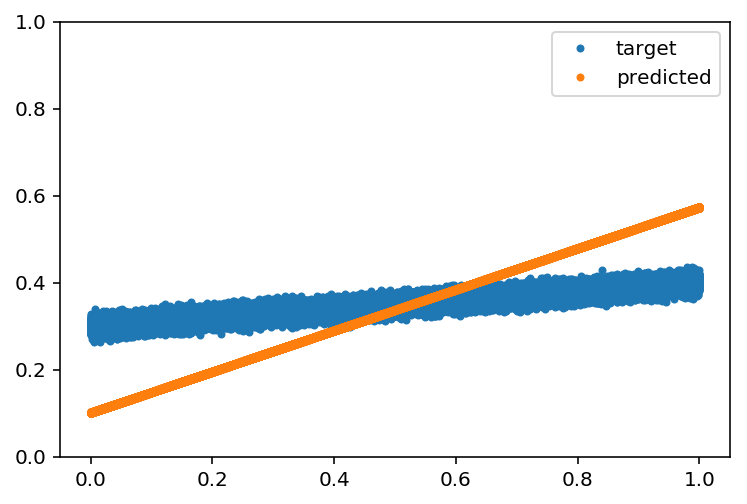

In [16]:
# Plot the predicted values
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, feed_dict={x_observed: x_train, y_observed: y_train}), ".", label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

In [17]:
# Check accuracy on eval data after training
# Note:  This should be close to 0!
test(x=x_test, y=y_test)

0.011777466

In [18]:
#https://github.com/tensorflow/serving/blob/master/tensorflow_serving/example/mnist_saved_model.py

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat

# Save the model
export_path = "/root/models/linear/cpu/%s" % version
with tf.device("/cpu:0"):
  builder = saved_model_builder.SavedModelBuilder(export_path)
  print(export_path)

###################################################
# Re-Run the Notebook from the Top if you see the following error: 
#
#  "Export directory already exists. Please specify a different export directory"
###################################################

/root/models/linear/cpu/1490850372


In [19]:
tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

name: "x_observed:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}

name: "add:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}



In [103]:
prediction_signature =  signature_def_utils.build_signature_def(
    inputs = {'x_observed': tensor_info_x_observed}, 
    outputs = {'y_pred': tensor_info_y_pred}, 
    method_name = signature_constants.PREDICT_METHOD_NAME)            

builder.add_meta_graph_and_variables(sess, 
  [tag_constants.SERVING],
  signature_def_map={'predict':prediction_signature,
  signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature})

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


In [104]:
builder.save()

INFO:tensorflow:SavedModel written to: b'/root/models/linear/cpu/1490849938/saved_model.pb'


b'/root/models/linear/cpu/1490849938/saved_model.pb'

## Save the Model in Previous Tensorflow Model Format
We will use this later.

In [105]:
from tensorflow.python.framework import graph_io
graph_io.write_graph(sess.graph, "/root/models/optimize_me/", "unoptimized_cpu.pb")

'/root/models/optimize_me/unoptimized_cpu.pb'

In [106]:
sess.close()